# Cosmic Rays and Poisson Statistics
## AstroStats, C.R. Nugent

### Introduction and Motivation

A traditional introduction to Poisson involves counting cosmic rays or decays from a radioactive source. But since this is AstroStats, we’ll be doing a fun twist on this project-- we'll count cosmic rays that hit a detector on an Earth-orbiting telescope during a 7.7s exposure. While we do this, we'll learn about and practice using astronomical data!

Astronomical data is often in the form of images. These images are stored in astro-specific formats, since astronomers need the data in the image, but also additional information, like when the image was taken and what telescope settings were used. Most commonly, astronomers use FITS format to store image information and this additional information, which is called the "header" of the image.

To handle this data, astronomers have built their own Python libraries to help. Today, our goals are to

1. Take a measurement of cosmic rays. We'll combine our measurements as a class, and see if they are, indeed, a Poisson distribution.
2. Practice using Python generally
3. Learn about astro-specific Python libraries such as Astropy and Astroquery.

### Data context and basic importing.

We are using data from NEOWISE, which was an infrared telescope that orbited Earth. There’s some confusing terminology here. Originally, the spacecraft and mission was named WISE, for Wide-field Infrared Survey Explorer. Over time, its purpose changed from surveying cold stars and luminous galaxies to discovering and studying asteroids. With this new objective came a new name, NEOWISE (Near-Earth Object WISE). Technically, the data we’ll work with is NEOWISE data. Over the course of its mission, NEOWISE made 1.45 million measurements of 44,000 asteroids and comets.

As you learned from your night assignment, cosmic rays can come from anywhere in the sky, but they are deflected by the Earth’s mag- netic field. NEOWISE sees cosmic rays as tiny splotches.

NEOWISE can get a cosmic ray detection anywhere in its orbit around Earth, but it gets a ton of them when it passes through the South Atlantic Anomaly (SAA, pronounced “saw”). The SAA is a place where the Van Allen radiation belt dips down, and the NEOWISE spacecraft travels right through it (Figure 2). When NEOWISE is traveling through the SAA, it’s detectors get bombarded with cosmic rays.

I've pulled some frames (images) taken by NEOWISE in the SAA for you to use today. All NEOWISE data is free to use and available via Caltech/IPAC's [WISE Image Server](https://irsa.ipac.caltech.edu/applications/wise/?__action=layout.showDropDown&). Let's load them and take a look.

If you get stuck, please look at the [astropy documentation](https://docs.astropy.org/en/stable/io/fits/usage/headers.html).

In [6]:
# First we need to import the tools to help us out
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# you'll want to update this with the name of the fits file you want to use
# and where the fits file is located.
file_path="47509b175-w1-int-1b.fits"
hdulist = fits.open(file_path)
hdu = hdulist[0]
# we can look at the header
print(hdu.header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 1016 / length of data axis 1                          NAXIS2  =                 1016 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H TELESCOP= 'WISE    '                                                            BUNIT   = 'DN      '                                                            EQUINOX =                 2000                                                  RADECSYS= 'FK5     '                                                            FILETYPE= 'intensity image frame'       

In [7]:
# or at specific header values
print(hdu.header['DATE_OBS'])
# to know what each one means, we could look at the documentation: https://wise2.ipac.caltech.edu/docs/release/allwise/
# but things like DATE_OBS are pretty standard.

2014-04-01T09:56:49.638


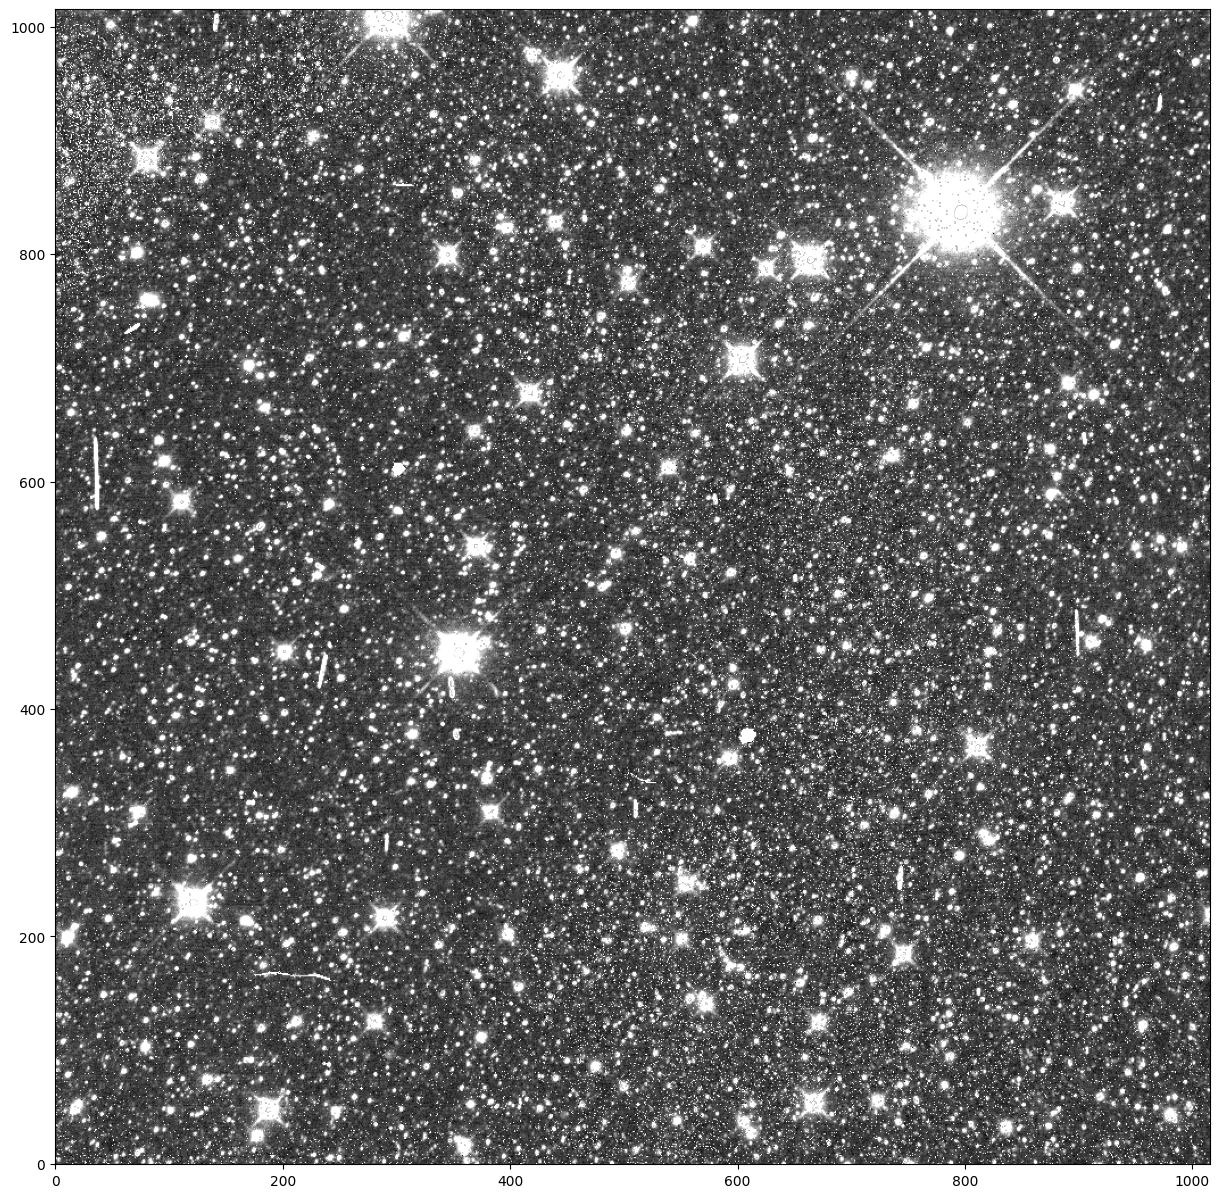

In [8]:
# Now let's look at the image.
telescope_image= hdulist[0].data
# Compute zscale limits, this will scale the pixels so we can see the full structure of the image
# without very bright regions washing dim features out
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(telescope_image)

plt.subplots(figsize=(15, 15))
plt.imshow(telescope_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.show()

# What are we seeing?

There’s lots of bright points in this image. Broadly, bright points can be stationary sources, transients, or artifacts.

**Stationary Sources**

Stationary sources are things like stars, groups of stars, galaxies, and nebulas. We are going to identify those using a catalog. Specifically, we’ll use the AllWISE Source Catalog. This was made from WISE data, by adding, or stacking, many images so that all stationary sources are identified.

**Transients**

Transients are things that change relative to the positions of the stars. These are cosmic rays, which are not things out in space, but actual particles hitting the detector of the telescope. Other transients are asteroids, comets, artificial satellites, or moons. These are things out in space that change position relative to the stars. Lucky for us, cosmic rays have a distinctive look– they have a sharp transition from bright to dark, in other words, they don’t look fuzzy. So we’ll be able to spot the cosmic rays by how they look. Also, it’s pretty unlikely that there will be an asteroid, comet, artificial satellite, or moon in the area we look.

**Artifacts**

However, we'll have to watch out for artifacts. Artifacts are not real things out in space but rather consequences of the telescope and its detectors, and the way it gathers and detects light. If you stare at a bright light for too long and look away, sometimes you still see that bright light in your field of view for a second or two (don’t do this now, it’s not great for you). Telescope detectors experience a similar effect, these are called “latents.” “Diffraction spikes” happen because of light diffracting around the support structures of the telescope. More on NEOWISE artifacts can be found [here](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4g.html) (optional reading).

IPAC scientists review every single frame NEOWISE returns. Sometimes, they find odd combinations of latents. Take a couple of minutes to just [look over the pictures of example latents](https://wise2.ipac.caltech.edu/docs/release/neowise/expsup/sec3_2c.html) now (you don’t have to read the text). The big take away is that sometimes telescopes pick up unusual light patterns. Sometimes people see these and think they might be aliens. Spoiler alert: so far, it's never been aliens.

In [11]:
# Now that we have some sense of what we are looking at, let's make our lives a little easier by marking the stars. We'll do this by querying the AllWISE catalog.
# We'll need the astroquery library, you may need to run pip to install if you're using Google Colab.

#!pip install astroquery

from astroquery.ipac.irsa import Irsa
import pandas as pd


In [13]:
# We shouldn't just ask for all the sources in the AllWISE catalog because there are 747,634,026 and it would be rude to hammer the servers.
# Let's instead figure out what the corners are of our full image in terms of RA (Right Ascension) and Dec (Declination).
# To do this, we'll need to covert pixels to coordinates. This coordinate transform using a "World Coordinate System" (WCS) or
# coordinate-transform convention developed for astronomy. The WCS info is, helpfully, in the header of the image!

# get the wcs from the header, call it w
w = WCS(hdulist[0].header)

frame_corner_1 = w.pixel_to_world(0, 0)
frame_corner_2 = w.pixel_to_world(0, telescope_image.shape[0])
frame_corner_3 = w.pixel_to_world(telescope_image.shape[0], telescope_image.shape[0])
frame_corner_4 = w.pixel_to_world(telescope_image.shape[0], 0)
print("Check our results:", frame_corner_1, frame_corner_2, frame_corner_3, frame_corner_4)
print("These corners are in Astropy \"SkyCoord\" format.")

Check our results: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (281.13377632, -39.67408096)> <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (281.04987291, -38.90234052)> <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (280.05123337, -38.96516971)> <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (280.12506093, -39.73515114)>
These corners are in Astropy "SkyCoord" format.


In [15]:
# Now we ask for three columns of data - the location (ra,dec) and brightness of sources in our region.
print("Note that this query may take a minute!")
results_allwise = Irsa.query_region(catalog="allwise_p3as_psd", spatial="Polygon",
                        polygon=[frame_corner_1,frame_corner_2,frame_corner_3,frame_corner_4], columns="ra,dec,w1mpro")
# Putting the results in pandas format to make it easier for most people to use
neowise_sources = results_allwise.to_pandas()
neowise_sources.describe() #Take a a look at the results. How many sources did you get?

Note that this query may take a minute!


ra           dec        w1mpro
count  13651.000000  13651.000000  13651.000000
mean     280.593594    -39.325076     14.867006
std        0.293042      0.221009      1.497028
min      280.053889    -39.733682      0.263000
25%      280.340536    -39.512923     14.161000
50%      280.600846    -39.328687     15.154000
75%      280.845595    -39.142236     15.927000
max      281.129951    -38.903236     18.607000

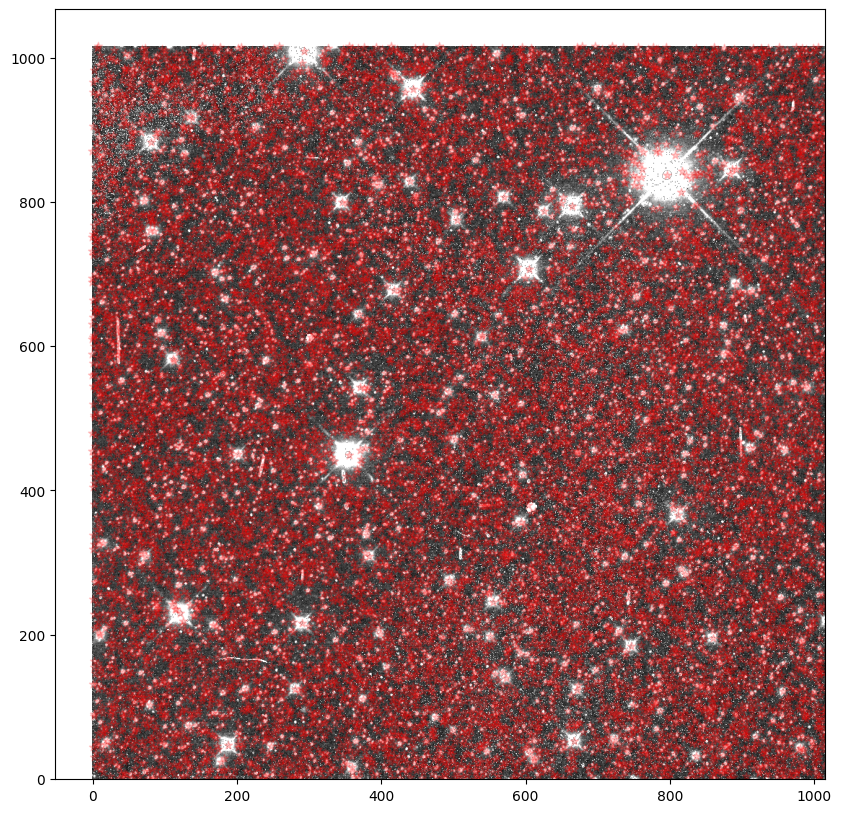

In [23]:
# Now let's try marking the stars
# First, we need to convert the neowise source positions into pixel positions, using the WCS header.
pixel_coords = w.world_to_pixel_values(neowise_sources['ra'], neowise_sources['dec'])

# I like putting the coords back together with the sources, so all the information is one dataframe.
neowise_sources['x_coord']=pixel_coords[0]
neowise_sources['y_coord']=pixel_coords[1]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(telescope_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.scatter(neowise_sources['x_coord'], neowise_sources['y_coord'], marker='*', color='red', alpha=0.2)
plt.show()

Ranomly chosen center: 722 283
lims 647 797 208 358


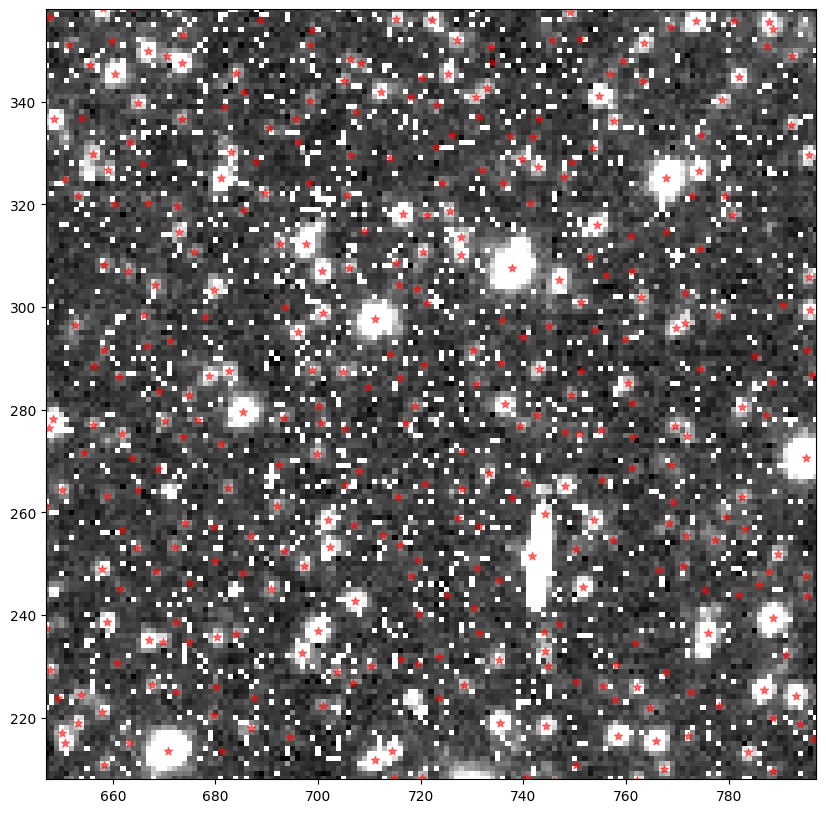

In [27]:
# This is too big to do our cosmic ray counting. Let's randomly select a subset of the image for today's experiment.
new_image_size = 150 #pixels. DO NOT CHANGE THIS-- this needs to be the same so we can compare our work with other people in the class.

full_img_width=telescope_image.shape[0]
full_img_height=telescope_image.shape[1]
buffer = new_image_size // 2 #we will want to select a subset of the big image that is entirely within the big image
cropped_center_x=np.random.randint(buffer,full_img_width-buffer)
cropped_center_y=np.random.randint(buffer,full_img_height-buffer)
print("Ranomly chosen center:",cropped_center_x,cropped_center_y)

x_min = cropped_center_x-buffer
x_max = cropped_center_x+buffer
y_min = cropped_center_y-buffer
y_max = cropped_center_y+buffer
print("lims", x_min, x_max, y_min, y_max)

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(telescope_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.scatter(neowise_sources['x_coord'], neowise_sources['y_coord'], marker='*', color='red', alpha=0.5)
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min, y_max)
# give your figure a more descriptive name
plt.savefig("myfig.png")

## Count the rays

Take your saved .png figure file and move it into something like Powerpoint or Illustrator where you can draw on it. Draw circles around all the cosmic rays.


This process of identifying the cosmic rays is not easy. Like most projects with real data, you’re going to have to make some judgement calls. You had do make judgement calls with your M&Ms, but they were fairly straightforward (“I’ll count a broken M&M as
0.5 M&Ms.”). The trick is to be consistent. Figure out what type of thing counts, to you, as a cosmic ray, and count all the things that look like that. This is your method for counting cosmic rays.

## Final tasks

To finish this exercise, please:
1. Add your results to [this spreadsheet](https://docs.google.com/spreadsheets/d/14yLu2VGFSYF7ekMYuWg9oRSSHuaetmg0ZZkGvzVHcrU/edit?usp=sharing), so the class has a larger dataset to look at for homework.
2. Think carefully about how you would describe your method for counting cosmic rays. How could you explain what you did to another student, so they would be counting in the same way you did? Were there any edge cases, or judgement calls? What were they, and how did you handle them?
3. Submit your image (with the cosmic rays circled) to Canvas.
4. Repeat the counting for other images and sections of images, if you have time. This will make the results a little nicer for your homework exercise.